<a href="https://colab.research.google.com/github/amirparizi/FaceClassificationWithInception/blob/main/TrainV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
from shutil import copyfile
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Test_dir ='/content/drive/My Drive/Fake Faces/First600/'

In [ ]:
len(os.listdir(Test_dir))

500

In [ ]:
TRAINING_DIR = "/content/drive/My Drive/Fake Faces/Training/"
TESTING_DIR = "/content/drive/My Drive/Fake Faces/Testing/"

In [ ]:
print(len(os.listdir(TRAINING_DIR)))
print(len(os.listdir(TESTING_DIR)))

450
50


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
traindf=pd.read_csv('/content/drive/My Drive/Fake Faces/faces_dataset.csv',dtype=str)

In [ ]:
def append_ext(fn):
    return "image_"+fn+'.jpg'

traindf["ID"]=traindf["ID"].apply(append_ext)


In [ ]:
traindf

,ID,SEX,EXPRESSIONS,AGE,Unnamed: 4,Unnamed: 5
0,image_1.jpg,Female,Happy,Adult,NaN,NaN
1,image_2.jpg,Female,Happy,Adult,NaN,NaN
2,image_3.jpg,Male,Neutral,Kid,NaN,NaN
3,image_4.jpg,Male,Neutral,Kid,NaN,NaN
4,image_5.jpg,Male,Neutral,Adult,NaN,NaN
...,...,...,...,...,...,...
495,image_496.jpg,Female,Happy,Adult,NaN,NaN
496,image_497.jpg,Male,Happy,Adult,NaN,NaN
497,image_498.jpg,Male,Neutral,Adult,NaN,NaN
498,image_499.jpg,Female,Neutral,Adult,NaN,NaN


In [ ]:
traindf["EXPRESSIONS"].value_counts()

Happy      259
Neutral    241
Name: EXPRESSIONS, dtype: int64

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=traindf,
directory=TESTING_DIR,
x_col="ID",
y_col="SEX",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(150,150))

Found 50 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 450 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=TRAINING_DIR,
x_col="ID",
y_col="SEX",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(150,150))

Found 450 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 50 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/content/drive/My Drive/Fake Faces/inception_v3_weights.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           
model = Model( pre_trained_model.input, x) 
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
history = model.fit_generator(train_generator,
            validation_data = test_generator,
            steps_per_epoch = 10,
            epochs = 10,
            verbose = 1,
            )


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
10/10 [==============================] - 42s 4s/step - loss: 1.3647 - accuracy: 0.6200 - val_loss: 0.8488 - val_accuracy: 0.5400
Epoch 2/10
10/10 [==============================] - 29s 3s/step - loss: 0.7595 - accuracy: 0.6900 - val_loss: 0.6684 - val_accuracy: 0.6000
Epoch 3/10
10/10 [==============================] - 22s 2s/step - loss: 0.4196 - accuracy: 0.8100 - val_loss: 0.4090 - val_accuracy: 0.7800
Epoch 4/10
10/10 [==============================] - 19s 2s/step - loss: 0.6403 - accuracy: 0.7200 - val_loss: 0.4809 - val_accuracy: 0.8400
Epoch 5/10
10/10 [==============================] - 16s 2s/step - loss: 0.5706 - accuracy: 0.7300 - val_loss: 0.3273 - val_accuracy: 0.8200
Epoch 6/10
10/10 [==============================] - 16s 2s/step - loss: 0.4630 - accuracy: 0.7700 - val_loss: 0.3387 - val_accuracy: 0.8600
Epoch 7/10
10/10 [==============================] - 15s 2s/step - loss: 0.6250 - acc

Text(0.5, 1.0, 'Training and validation loss')

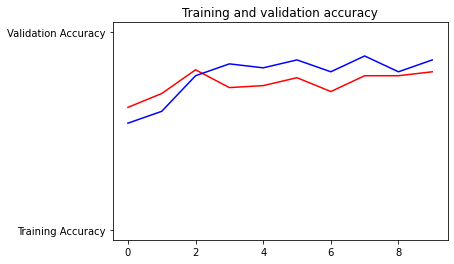

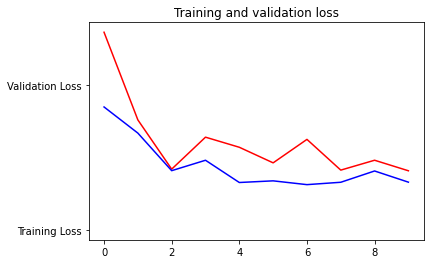

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [ ]:
train_datagen_2 = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_generator_2=train_datagen_2.flow_from_dataframe(
dataframe=traindf,
directory=TRAINING_DIR,
x_col="ID",
y_col="EXPRESSIONS",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(150,150))

test_datagen_2 = ImageDataGenerator(rescale = 1./255.)
test_generator_2=test_datagen_2.flow_from_dataframe(
dataframe=traindf,
directory=TESTING_DIR,
x_col="ID",
y_col="EXPRESSIONS",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(150,150))

Found 450 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 50 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 450 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           
model_2 = Model( pre_trained_model.input, x) 
model_2.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
history_2 = model_2.fit_generator(train_generator_2,
            validation_data = test_generator_2,
            steps_per_epoch = 10,
            epochs = 10,
            verbose = 1,
            )


Epoch 1/10
10/10 [==============================] - 14s 1s/step - loss: 1.2730 - accuracy: 0.5200 - val_loss: 0.6563 - val_accuracy: 0.6200
Epoch 2/10
10/10 [==============================] - 16s 2s/step - loss: 0.8273 - accuracy: 0.5900 - val_loss: 0.7042 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 12s 1s/step - loss: 0.7156 - accuracy: 0.6000 - val_loss: 0.4969 - val_accuracy: 0.8000
Epoch 4/10
10/10 [==============================] - 12s 1s/step - loss: 0.6653 - accuracy: 0.6700 - val_loss: 0.5545 - val_accuracy: 0.7200
Epoch 5/10
10/10 [==============================] - 13s 1s/step - loss: 0.7662 - accuracy: 0.5600 - val_loss: 0.4581 - val_accuracy: 0.8400
Epoch 6/10
10/10 [==============================] - 12s 1s/step - loss: 0.7101 - accuracy: 0.6700 - val_loss: 0.4814 - val_accuracy: 0.8000
Epoch 7/10
10/10 [==============================] - 12s 1s/step - loss: 0.6726 - accuracy: 0.6600 - val_loss: 0.4973 - val_accuracy: 0.7600
Epoch 8/10
10/10 [==

Text(0.5, 1.0, 'Training and validation loss')

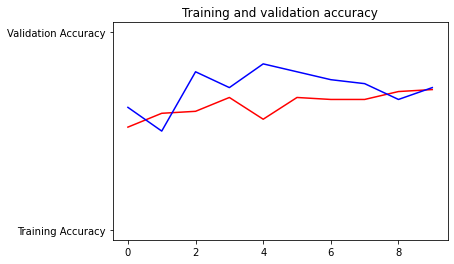

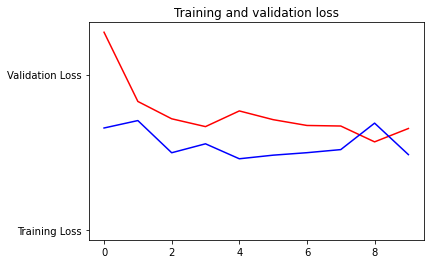

In [ ]:
acc=history_2.history['accuracy']
val_acc=history_2.history['val_accuracy']
loss=history_2.history['loss']
val_loss=history_2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

Saving test15.jpg to test15 (1).jpg


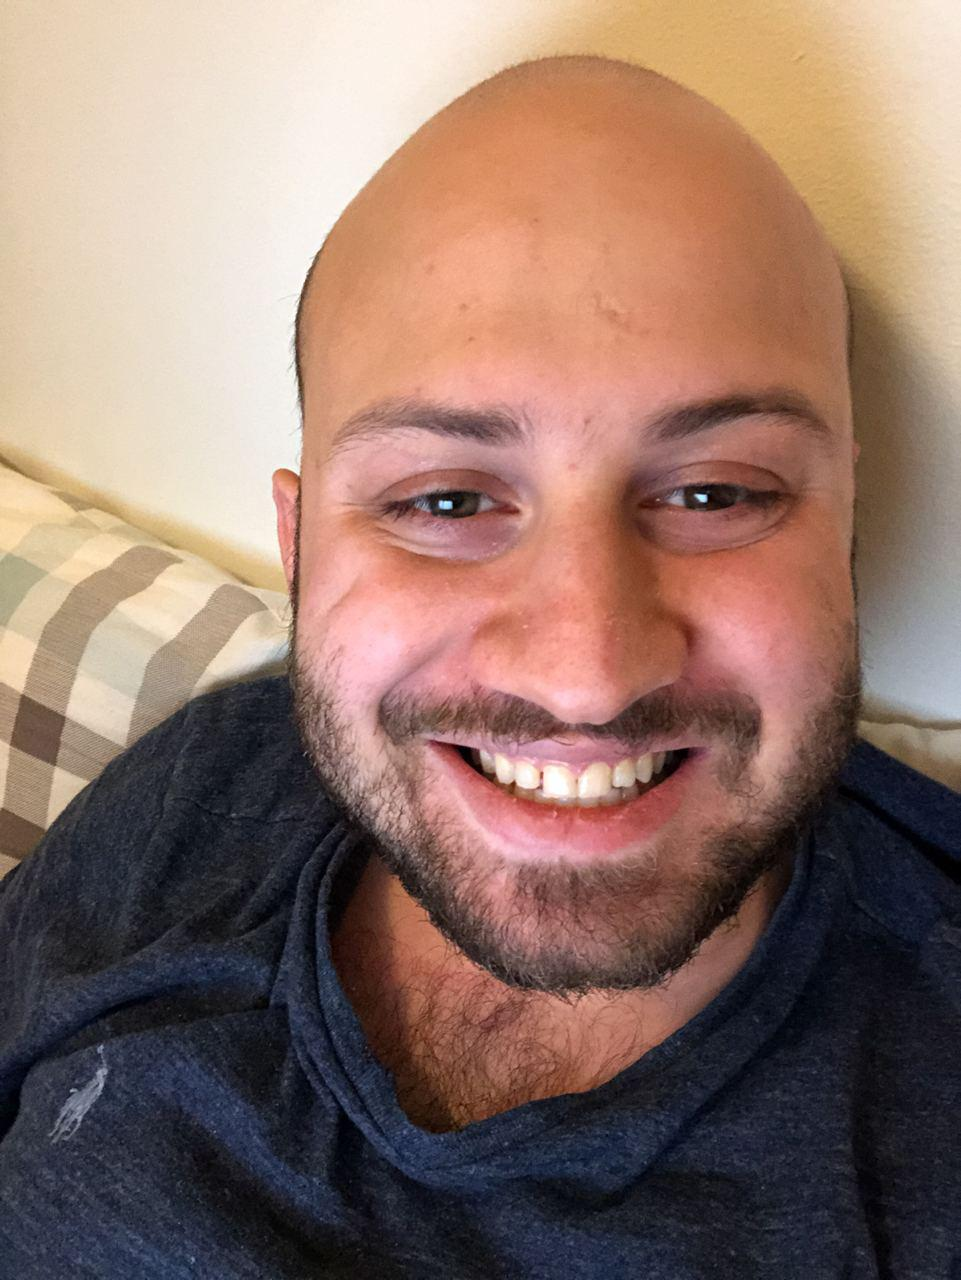

This is a Male
This person looks like Happy


In [ ]:

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x=x/255
  x = np.expand_dims(x, axis=0)
  display(Image(path))
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  if (classes[0]) < 0.5:
    print('This is a Female')
  else:
    print('This is a Male')
  classes_2 = model_2.predict(images, batch_size=10)
  if (classes_2[0]) < 0.5:
    print('This person looks like Happy')
  else:
    print('This person looks like Neutral')


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


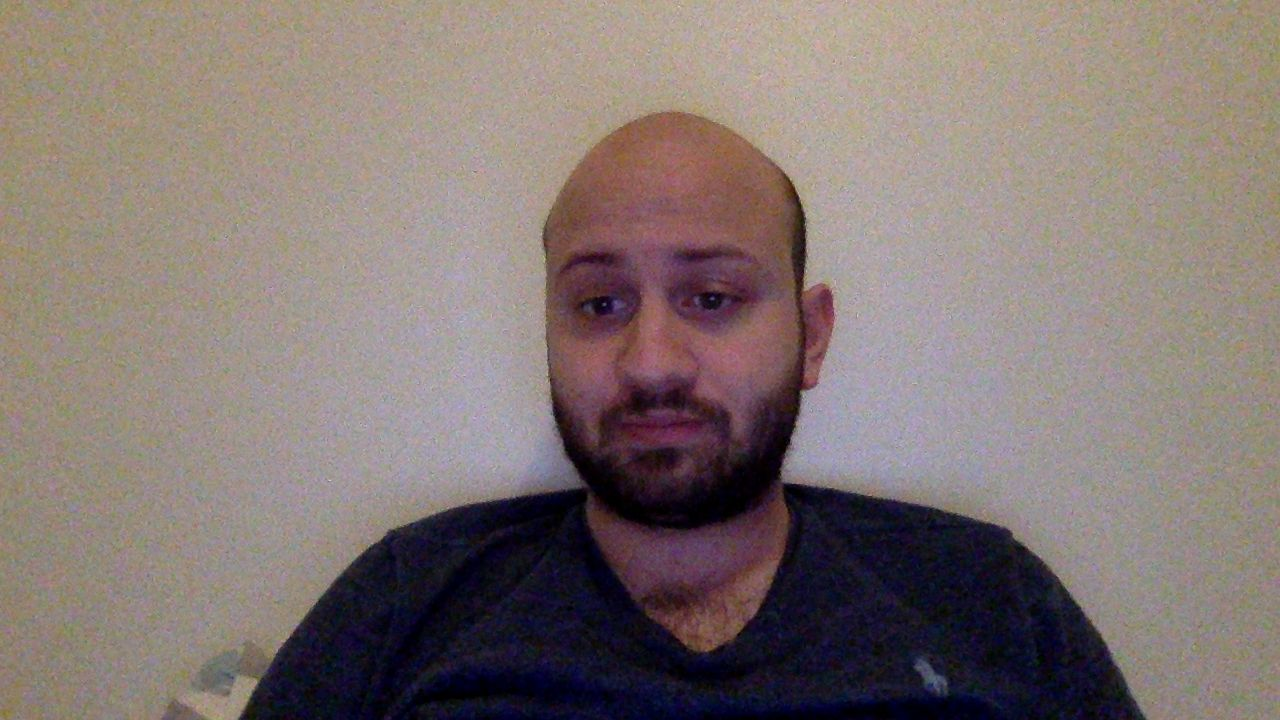

This is a Male
This person looks like Neutral


In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
path = '/content/photo.jpg'
img = image.load_img(path, target_size=(150,150))
x = image.img_to_array(img)
x=x/255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
if (classes[0]) < 0.5:
  print('This is a Female')
else:
  print('This is a Male')
classes_2 = model_2.predict(images, batch_size=10)
if (classes_2[0]) < 0.5:
  print('This person looks like Happy')
else:
  print('This person looks like Neutral')